## Shorten the names of superoperator files

In [157]:
import os
import shutil

folder = r'C:\Users\ssingh8\OneDrive - Delft University of Technology\Research\[PROJECTS]\Emission based direct schemes\simulations_data\1_basic_first_simulation\0_first_rates_at_inf_cutoff\New folder'

def copy_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith("merged.csv"):
            source = os.path.join(directory, filename)
            destination = os.path.join(directory, "copy_" + filename)
            shutil.copy2(source, destination)

# for EM Direct WT4
def rename_files(directory):
    for filename in os.listdir(directory):
        if filename.startswith("copy_"):
            bell_type = filename[filename.find("bell_pair_type-")+len("bell_pair_type-"):filename.rfind("_network_")]
            nn_type =  filename[filename.find("network_noise_type-")+len("network_noise_type-"):filename.rfind("_p_g")]
            set_parameters = filename[filename.find("hc_direct_ghz_node-")+len("hc_direct_ghz_node-"):filename.rfind("_bell_pair_type")]
            pg_val = float(filename[filename.find("p_g-")+len("p_g-"):filename.rfind("_p_m")])
            new_filename = filename.replace(filename, f"copy_{set_parameters}_bell_{bell_type}_nntype_{nn_type}_p_g-{pg_val}_p_m_.csv")
            source = os.path.join(directory, filename)
            destination = os.path.join(directory, new_filename)
            os.rename(source, destination)


copy_files(folder)
rename_files(folder)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\ssingh8\\OneDrive - Delft University of Technology\\Research\\[PROJECTS]\\Emission based direct schemes\\simulations_data\\1_basic_first_simulation\\0_first_rates_at_inf_cutoff\\New folder'

# Comparison of various direct emission protocols

In [1]:
from circuit_simulation.circuit_simulator import QuantumCircuit

bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":0.02}
# Coherence parameters
# T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6

raw_state_qc = QuantumCircuit(1,network_noise_type=100, bell_pair_parameters=bell_pair_parameters, T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6)
dc_state_qc = QuantumCircuit(1,network_noise_type=101, bell_pair_parameters=bell_pair_parameters, T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6)
bell_distilled_state_qc = QuantumCircuit(1,network_noise_type=102, bell_pair_parameters=bell_pair_parameters, T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6)
basic_distilled_state_qc = QuantumCircuit(1,network_noise_type=103, bell_pair_parameters=bell_pair_parameters, T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6)
w_distilled_state_qc = QuantumCircuit(1,network_noise_type=104, bell_pair_parameters=bell_pair_parameters, T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6)


# print(raw_state_qc.noisy_bell_state)

c:\emission_direct_scheme\circuit_simulation\basic_operations\basic_operations.py:2: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.22.3)
  from scipy import sparse as sp


*** GHZ state fidelity of Raw state is 0.9059216696673313.***
*** Success probability of Raw state is 0.0002497544073894324.***
*** GHZ state fidelity of DC direct emission state is 0.9344095096801976.***
*** Success probability of DC direct emission state is 1.0486373954611283e-05.***
*** GHZ state fidelity of Basic protocol state is 0.616946746897028.***
*** Success probability of Basic protocol state is (0.0001901246877192783+0j).***


## Bright state parameter influence

*** GHZ state fidelity of Raw state is 0.8839184183342568.***
*** Success probability of Raw state is 0.001540796087300688.***
*** GHZ state fidelity of DC direct emission state is 0.9344003180613876.***
*** Success probability of DC direct emission state is 6.159112921267248e-05.***
*** GHZ state fidelity of Basic protocol state is 0.5899056048215436.***
*** Success probability of Basic protocol state is (0.0010723590162540746+0j).***
*** GHZ state fidelity of Raw state is 0.8466543751735244.***
*** Success probability of Raw state is 0.006029135068949614.***
*** GHZ state fidelity of DC direct emission state is 0.9343836379088934.***
*** Success probability of DC direct emission state is 0.00022113026014045203.***
*** GHZ state fidelity of Basic protocol state is 0.5435940765030338.***
*** Success probability of Basic protocol state is (0.003563152746539629+0j).***
*** GHZ state fidelity of Raw state is 0.8086230509392711.***
*** Success probability of Raw state is 0.0132650974029163

c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


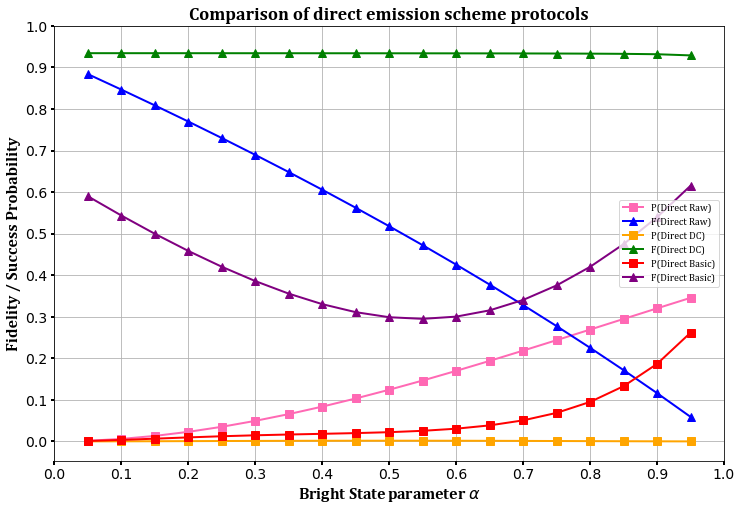

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from circuit_simulation.circuit_simulator import QuantumCircuit

# Bright State parameter alpha
alpha = np.arange(0.05, 1.0, 0.05)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the curves with specified markers and colors
raw_p = []
raw_f = []
dc_state_p = []
dc_state_f = []
basic_state_p = []
basic_state_f = []

for alpha_val in alpha:
    bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":alpha_val}
    raw_state_qc = QuantumCircuit(1,network_noise_type=100, bell_pair_parameters=bell_pair_parameters, T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6)
    raw_p.append(raw_state_qc.p_link)
    raw_f.append(raw_state_qc.F_link)

    dc_state_qc = QuantumCircuit(1,network_noise_type=101, bell_pair_parameters=bell_pair_parameters, T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6)
    dc_state_p.append(dc_state_qc.p_link)
    dc_state_f.append(dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(1,network_noise_type=103, bell_pair_parameters=bell_pair_parameters, T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6)
    basic_state_p.append(basic_distilled_state_qc.p_link)
    basic_state_f.append(basic_distilled_state_qc.F_link)


ax.plot(alpha, raw_p, marker='s', color='#FF69B4', label='P(Direct Raw)', linestyle='-', linewidth=2, markersize=8)  # Hot Pink
ax.plot(alpha, raw_f, marker='^', color='#0000FF', label='F(Direct Raw)', linestyle='-', linewidth=2, markersize=8)  # Blue
ax.plot(alpha, dc_state_p, marker='s', color='#FFA500', label='P(Direct DC)', linestyle='-', linewidth=2, markersize=8)  # Orange
ax.plot(alpha, dc_state_f, marker='^', color='#008000', label='F(Direct DC)', linestyle='-', linewidth=2, markersize=8)  # Green
ax.plot(alpha, basic_state_p, marker='s', color='#FF0000', label='P(Direct Basic)', linestyle='-', linewidth=2, markersize=8)  # Red
ax.plot(alpha, basic_state_f, marker='^', color='#800080', label='F(Direct Basic)', linestyle='-', linewidth=2, markersize=8)  # Purple

# Enable grid
ax.grid(True)

# Set bold axis ticks and labels
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax.set_xlabel(r'Bright State parameter $\alpha$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_ylabel('Fidelity / Success Probability', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

# Show the plot
plt.show()


## Effective photon detection probability influence (@ alpha = 0.1)

*** GHZ state fidelity of Raw state is 0.9020462283960564.***
*** Success probability of Raw state is 1.2584759130409765e-09.***
*** GHZ state fidelity of DC direct emission state is 0.9342469721139242.***
*** Success probability of DC direct emission state is 2.6181474867586644e-16.***
*** GHZ state fidelity of Basic protocol state is 0.24999988839482146.***
*** Success probability of Basic protocol state is (1.5730934867772452e-10+0j).***
*** GHZ state fidelity of Raw state is 0.9021239232180402.***
*** Success probability of Raw state is 1.2582591340976207e-07.***
*** GHZ state fidelity of DC direct emission state is 0.9342502546852836.***
*** Success probability of DC direct emission state is 2.6181289311509175e-12.***
*** GHZ state fidelity of Basic protocol state is 0.249999987273483.***
*** Success probability of Basic protocol state is (1.5728237574894668e-08+0j).***
*** GHZ state fidelity of Raw state is 0.9024694756550132.***
*** Success probability of Raw state is 3.14323938

c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


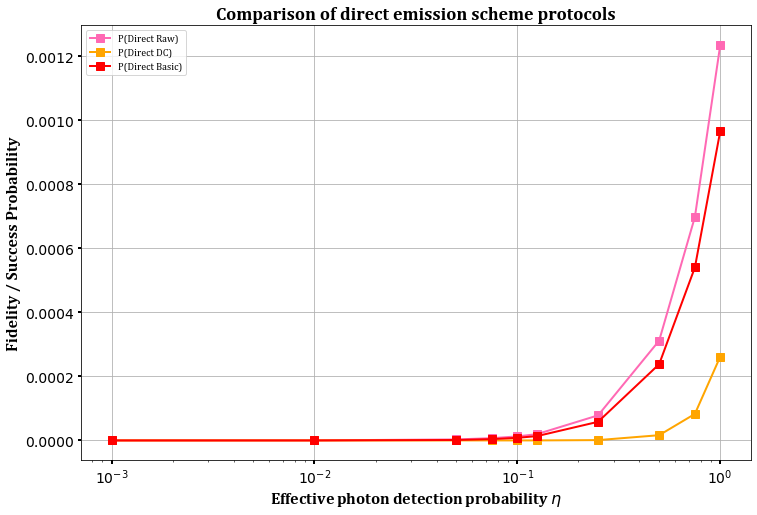

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from circuit_simulation.circuit_simulator import QuantumCircuit

# Effective photon detection probability eta
# eta = np.array([1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1, 1.0])
eta = np.array([1e-3,1e-2,0.05,0.075,1e-1,0.125,0.25,0.5,0.75, 1.0])


# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the curves with specified markers and colors
raw_p = []
raw_f = []
dc_state_p = []
dc_state_f = []
basic_state_p = []
basic_state_f = []

for eta_val in eta:
    bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":eta_val,"alpha":0.02}
    raw_state_qc = QuantumCircuit(1,network_noise_type=100, bell_pair_parameters=bell_pair_parameters, T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6)
    raw_p.append(raw_state_qc.p_link)
    raw_f.append(raw_state_qc.F_link)

    dc_state_qc = QuantumCircuit(1,network_noise_type=101, bell_pair_parameters=bell_pair_parameters, T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6)
    dc_state_p.append(dc_state_qc.p_link)
    dc_state_f.append(dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(1,network_noise_type=103, bell_pair_parameters=bell_pair_parameters, T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6)
    basic_state_p.append(basic_distilled_state_qc.p_link)
    basic_state_f.append(basic_distilled_state_qc.F_link)


ax.plot(eta, raw_p, marker='s', color='#FF69B4', label='P(Direct Raw)', linestyle='-', linewidth=2, markersize=8)  # Hot Pink
# ax.plot(eta, raw_f, marker='^', color='#0000FF', label='F(Direct Raw)', linestyle='-', linewidth=2, markersize=8)  # Blue
ax.plot(eta, dc_state_p, marker='s', color='#FFA500', label='P(Direct DC)', linestyle='-', linewidth=2, markersize=8)  # Orange
# ax.plot(eta, dc_state_f, marker='^', color='#008000', label='F(Direct DC)', linestyle='-', linewidth=2, markersize=8)  # Green
ax.plot(eta, basic_state_p, marker='s', color='#FF0000', label='P(Direct Basic)', linestyle='-', linewidth=2, markersize=8)  # Red
# ax.plot(eta, basic_state_f, marker='^', color='#800080', label='F(Direct Basic)', linestyle='-', linewidth=2, markersize=8)  # Purple

# Enable grid
ax.grid(True)

# Set x-axis to log scale
ax.set_xscale('log')

# Set bold axis ticks and labels
ax.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax.set_xlabel(r'Effective photon detection probability $\eta$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_ylabel('Success Probability', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

# Show the plot
plt.show()


*** GHZ state fidelity of Raw state is 0.9020462283960564.***
*** Success probability of Raw state is 1.2584759130409765e-09.***
*** GHZ state fidelity of DC direct emission state is 0.9342469721139242.***
*** Success probability of DC direct emission state is 2.6181474867586644e-16.***
*** GHZ state fidelity of Basic protocol state is 0.24999988839482146.***
*** Success probability of Basic protocol state is (1.5730934867772452e-10+0j).***
*** GHZ state fidelity of Raw state is 0.9021239232180402.***
*** Success probability of Raw state is 1.2582591340976207e-07.***
*** GHZ state fidelity of DC direct emission state is 0.9342502546852836.***
*** Success probability of DC direct emission state is 2.6181289311509175e-12.***
*** GHZ state fidelity of Basic protocol state is 0.249999987273483.***
*** Success probability of Basic protocol state is (1.5728237574894668e-08+0j).***
*** GHZ state fidelity of Raw state is 0.9024694756550132.***
*** Success probability of Raw state is 3.14323938

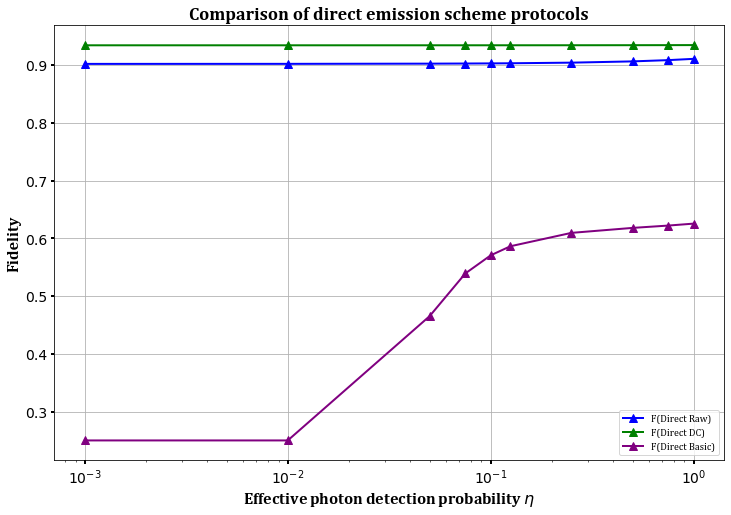

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from circuit_simulation.circuit_simulator import QuantumCircuit

# Effective photon detection probability eta
# eta = np.array([1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1, 1.0])
eta = np.array([1e-3,1e-2,0.05,0.075,1e-1,0.125,0.25,0.5,0.75, 1.0])


# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the curves with specified markers and colors
raw_p = []
raw_f = []
dc_state_p = []
dc_state_f = []
basic_state_p = []
basic_state_f = []

for eta_val in eta:
    bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":eta_val,"alpha":0.02}
    raw_state_qc = QuantumCircuit(1,network_noise_type=100, bell_pair_parameters=bell_pair_parameters, T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6)
    raw_p.append(raw_state_qc.p_link)
    raw_f.append(raw_state_qc.F_link)

    dc_state_qc = QuantumCircuit(1,network_noise_type=101, bell_pair_parameters=bell_pair_parameters, T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6)
    dc_state_p.append(dc_state_qc.p_link)
    dc_state_f.append(dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(1,network_noise_type=103, bell_pair_parameters=bell_pair_parameters, T2n_idle=1e6,T1n_idle=1e6,T2n_link=1e6,T1n_link=1e6,T2e_idle=1e6,T1e_idle=1e6,T2e_link=1e6,T1e_link=1e6)
    basic_state_p.append(basic_distilled_state_qc.p_link)
    basic_state_f.append(basic_distilled_state_qc.F_link)


# ax.plot(eta, raw_p, marker='s', color='#FF69B4', label='P(Direct Raw)', linestyle='-', linewidth=2, markersize=8)  # Hot Pink
ax.plot(eta, raw_f, marker='^', color='#0000FF', label='F(Direct Raw)', linestyle='-', linewidth=2, markersize=8)  # Blue
# ax.plot(eta, dc_state_p, marker='s', color='#FFA500', label='P(Direct DC)', linestyle='-', linewidth=2, markersize=8)  # Orange
ax.plot(eta, dc_state_f, marker='^', color='#008000', label='F(Direct DC)', linestyle='-', linewidth=2, markersize=8)  # Green
# ax.plot(eta, basic_state_p, marker='s', color='#FF0000', label='P(Direct Basic)', linestyle='-', linewidth=2, markersize=8)  # Red
ax.plot(eta, basic_state_f, marker='^', color='#800080', label='F(Direct Basic)', linestyle='-', linewidth=2, markersize=8)  # Purple

# Enable grid
ax.grid(True)

# Set x-axis to log scale
ax.set_xscale('log')

# Set bold axis ticks and labels
ax.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax.set_xlabel(r'Effective photon detection probability $\eta$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_ylabel('Fidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

# Show the plot
plt.show()


# Threshold data for direct emission scheme

Reduced chi squared is 2533.274371033828.
Least squared fitting on dataset results:
Threshold = 0.004513854076580802 +- 0.00039986980138172434
A= 0.9289872131757907 B= -16.596784566993772 C= 73.57059984291763
D= -1.9800000000000004 nu= 1.199989783802793 mu= 0.71

Reduced chi-squared for fit equals 2533.274371033828.
0.00039986980138172434
The LSR at threshold (pth): 0.9289872131757907 +- 0.05263418772823669


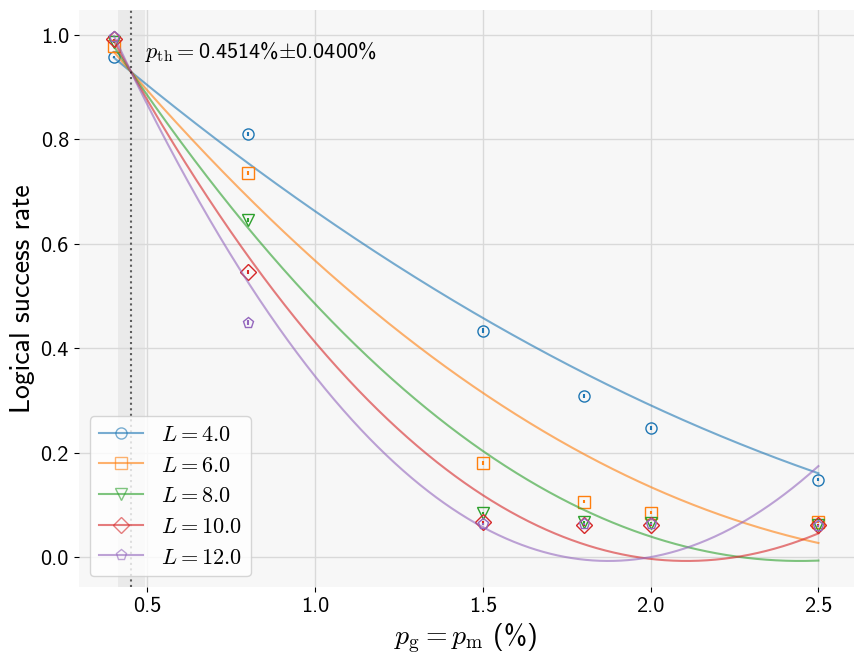

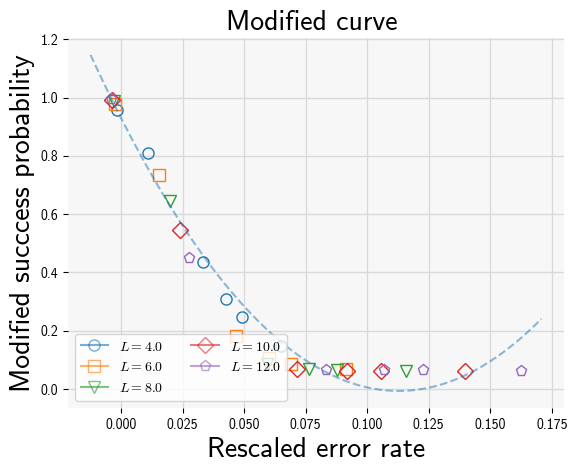

(<Figure size 1000x750 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

In [22]:
import pandas as pd
from oopsc.threshold.plot import plot_thresholds
# import seaborn as sns


### DATA FOR THE THRESHOLDS FOR DIFFERENT CASES ###

# RAW FIRST SIMULATION WITH NO-CUTOFF
# @ INF
# data = {"(4, 4)":{"0":[0.00001,0.14674],"1":[0.0001,0.14974],"2":[0.0005,0.14266],"3":[0.0008,0.13734],"4":[0.001,0.13724],"5":[0.002,0.12682],"6":[0.003,0.11836],"7":[0.004,0.11064]},"(6, 6)":{"0":[0.00001,0.07312],"1":[0.0001,0.0724],"2":[0.0005,0.07142],"3":[0.0008,0.06996],"4":[0.001,0.06756],"5":[0.002,0.06716],"6":[0.003,0.06568],"7":[0.004,0.06592]},"(8, 8)":{"0":[0.00001,0.06322],"1":[0.0001,0.06414],"2":[0.0005,0.0627],"3":[0.0008,0.0632],"4":[0.001,0.06374],"5":[0.002,0.06412],"6":[0.003,0.06404],"7":[0.004,0.06252]},"(10, 10)":{"0":[0.00001,0.06482],"1":[0.0001,0.0612],"2":[0.0005,0.06292],"3":[0.0008,0.0618],"4":[0.001,0.0615],"5":[0.002,0.0628],"6":[0.003,0.06246],"7":[0.004,0.06272]},"(12, 12)":{"0":[0.00001,0.06306],"1":[0.0001,0.06206],"2":[0.0005,0.06212],"3":[0.0008,0.06266],"4":[0.001,0.06216],"5":[0.002,0.06184],"6":[0.003,0.06158],"7":[0.004,0.06222]}}

# BASIC FIRST SIMULATION WITH NO-CUTOFF
# @ INF
# data = {"(4, 4)":{"0":[0.00001,0.9998],"1":[0.0001,0.99982],"2":[0.0005,0.9993],"3":[0.0008,0.99806],"4":[0.001,0.99732],"5":[0.002,0.99064],"6":[0.003,0.97748],"7":[0.004,0.95886]},"(6, 6)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,0.99976],"4":[0.001,0.99974],"5":[0.002,0.99804],"6":[0.003,0.9921],"7":[0.004,0.97586]},"(8, 8)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,0.99994],"5":[0.002,0.99948],"6":[0.003,0.99726],"7":[0.004,0.9865]},"(10, 10)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,1.0],"5":[0.002,0.99992],"6":[0.003,0.99878],"7":[0.004,0.99184]},"(12, 12)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,1.0],"5":[0.002,0.99996],"6":[0.003,0.99958],"7":[0.004,0.99578]}}
data = {"(4, 4)":{"0":[0.004,0.95792],"1":[0.008,0.80982],"2":[0.015,0.43398],"3":[0.018,0.30888],"4":[0.02,0.24822],"5":[0.025,0.14874]},"(6, 6)":{"0":[0.004,0.97788],"1":[0.008,0.7354],"2":[0.015,0.1808],"3":[0.018,0.10596],"4":[0.02,0.08518],"5":[0.025,0.06764]},"(8, 8)":{"0":[0.004,0.98632],"1":[0.008,0.64612],"2":[0.015,0.08508],"3":[0.018,0.06686],"4":[0.02,0.06604],"5":[0.025,0.0619]},"(10, 10)":{"0":[0.004,0.9917],"1":[0.008,0.5464],"2":[0.015,0.06674],"3":[0.018,0.06224],"4":[0.02,0.06272],"5":[0.025,0.061]},"(12, 12)":{"0":[0.004,0.99568],"1":[0.008,0.44886],"2":[0.015,0.06368],"3":[0.018,0.06378],"4":[0.02,0.06434],"5":[0.025,0.06028]}}
# data = {"(4, 4)":{"1":[0.001,0.99744],"2":[0.002,0.98984],"3":[0.003,0.9784],"4":[0.004,0.95926],"5":[0.008,0.8081]},"(6, 6)":{"1":[0.001,0.99978],"2":[0.002,0.99814],"3":[0.003,0.99278],"4":[0.004,0.97702],"5":[0.008,0.73422]},"(8, 8)":{"1":[0.001,0.99996],"2":[0.002,0.99962],"3":[0.003,0.99716],"4":[0.004,0.98624],"5":[0.008,0.648]},"(10, 10)":{"1":[0.001,1.0],"2":[0.002,1.0],"3":[0.003,0.99888],"4":[0.004,0.99244],"5":[0.008,0.54708]},"(12, 12)":{"1":[0.001,1.0],"2":[0.002,0.99998],"3":[0.003,0.99956],"4":[0.004,0.99526],"5":[0.008,0.44674]}}

# MEDIUM FIRST SIMULATION WITH NO-CUTOFF
# @ INF
# data = 


iters = 50000

rates = [rate[0] for rate in list(data["(6, 6)"].values())]

l4 = [rate[1] for rate in list(data["(4, 4)"].values())]
l6 = [rate[1] for rate in list(data["(6, 6)"].values())]
l8 = [rate[1] for rate in list(data["(8, 8)"].values())]
l10 = [rate[1] for rate in list(data["(10, 10)"].values())]
l12 = [rate[1] for rate in list(data["(12, 12)"].values())]

data_frame = pd.DataFrame(columns=["L", "p_g", "N", "success"])

for p_rate, success in zip(rates, l4):
    to_add = [4, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l6):
    to_add = [6, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l8):
    to_add = [8, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l10):
    to_add = [10, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l12):
    to_add = [12, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add


data_frame = data_frame.set_index(["L", "p_g"])
# sns.set(style="darkgrid")
plot_thresholds(data=data_frame,output="example_threshold", modified_ansatz=False, accuracy=None)

# Cirq code for basic protocol (development)

In [156]:
import cirq
"""
This script simulates a quantum circuit with noise and decoherence effects using Cirq. 
It generates two random 4-qubit density matrices, applies a series of quantum gates and noise channels, 
and then post-selects the second set of qubits (qubits_2) in the |0><0| state. 
Finally, it performs a partial trace over the first set of qubits (qubits_1) to obtain the distilled emitter's state.
Functions:
    random_density_matrix(num_qubits): Generates a random density matrix for a given number of qubits.
Variables:
    t_link (float): Link time.
    p_link_raw (float): Raw link probability.
    T1n_idle (float): T1 time for idle nuclear qubits.
    T2n_idle (float): T2 time for idle nuclear qubits.
    T1e_idle (float): T1 time for idle electron qubits.
    T2e_idle (float): T2 time for idle electron qubits.
    T1n_link (float): T1 time for nuclear qubits during link generation.
    T2n_link (float): T2 time for nuclear qubits during link generation.
    t_CX (float): Duration of the CNOT gate.
    pg (float): Gate noise probability.
Usage:
    - The script initializes two sets of 4 qubits each and creates a combined density matrix.
    - It applies noise channels and quantum gates to simulate decoherence and gate noise.
    - The final density matrix is post-selected based on the measurement outcome of the second set of qubits.
    - The partial trace is performed over the first set of qubits to obtain the final state of the emitters.
Note:
    To correctly use the `cirq.partial_trace` function, ensure that the indices provided for tracing out are within the valid range for the combined system. 
    In this case, since the combined system has 8 qubits, the indices for `qubits_2` should be [4, 5, 6, 7].
"""
import numpy as np

# Helper function to create a random density matrix for n qubits
def random_density_matrix(num_qubits):
    dim = 2**num_qubits
    random_state = np.random.rand(dim, dim) + 1j * np.random.rand(dim, dim)  # Random complex matrix
    random_state = random_state @ random_state.conj().T  # Make it Hermitian and positive semi-definite
    random_state /= np.trace(random_state)  # Normalize to make it a density matrix
    return random_state

t_link = 1e-6
p_link_raw = 0.001
T1n_idle = 10
T2n_idle = 10
T1e_idle = 10
T2e_idle = 10
T1n_link = 10
T2n_link = 10
t_CX = 0.001
pg = 0.01

density_matrix_1 = random_density_matrix(4)  # First 4-qubit density matrix
density_matrix_2 = random_density_matrix(4)  # Second 4-qubit density matrix

qubits_1 = [cirq.LineQubit(i) for i in range(4)]  # Qubits for density matrix 1
qubits_2 = [cirq.LineQubit(i + 4) for i in range(4)]  # Qubits for density matrix 2

simulator = cirq.DensityMatrixSimulator()
combined_density_matrix = np.kron(density_matrix_1, density_matrix_2)


# Decoherence after the SWAP gates, before the CNOT gates
pd_channel_after_SWAP = [cirq.PhaseDampingChannel(1-np.exp(-t_CX/T2n_idle)).on_each(qubits_2[i]) for i in range(4)]
gad_channel_after_SWAP = [cirq.GeneralizedAmplitudeDampingChannel(0.5, 1-np.exp(-t_CX/T1n_idle)).on_each(qubits_2[i]) for i in range(4)]
# Gate noise on the raw-2 qubits
noise_SWAP = [cirq.DepolarizingChannel(p=pg).on_each(qubits_2[i]) for i in range(4)]
# Then decoherence noiuse due to the second link generation
pd_channel_during_link = [cirq.PhaseDampingChannel(1-np.exp(-(t_CX+t_link/p_link_raw)/T2n_link)).on_each(qubits_2[i]) for i in range(4)]
gad_channel_during_link = [cirq.GeneralizedAmplitudeDampingChannel(0.5, 1-np.exp(-(t_CX+t_link/p_link_raw)/T2n_link)).on_each(qubits_2[i]) for i in range(4)]

# Apply the 4-CNOT gates in parallel within all the nodes
cnots = [cirq.CNOT(qubits_1[i], qubits_2[i]) for i in range(4)] # All these CNOT gates are parallel on the architecture

# Apply depolarizing noise to the qubits involved in the CNOT gates
depolarizing_noise = [cirq.DepolarizingChannel(p=pg).on_each(qubits_1[i], qubits_2[i]) for i in range(4)]

# Decoherence after the CNOT gates
# First on the memory qubits which suffer twice the duration of the two-qubit gates
pd_channel_after_CNOTs_m = [cirq.PhaseDampingChannel(1-np.exp(-2*t_CX/T2n_link)).on_each(qubits_2[i]) for i in range(4)]
gad_channel_after_CNOTs_m = [cirq.GeneralizedAmplitudeDampingChannel(0.5, 1-np.exp(-2*t_CX/T1n_link)).on_each(qubits_2[i]) for i in range(4)]
# The other raw state suffers this noise only for the duration of the CNOT gates, these are the communication qubits
pd_channel_after_CNOTs_c = [cirq.PhaseDampingChannel(1-np.exp(-t_CX/T2e_idle)).on_each(qubits_1[i]) for i in range(4)]
gad_channel_after_CNOTs_c = [cirq.GeneralizedAmplitudeDampingChannel(0.5, 1-np.exp(-t_CX/T1e_idle)).on_each(qubits_1[i]) for i in range(4)]

# Apply depolarizing noise to the qubits involved in the SWAP gates, beause the measurements are done only on the communication qubits
depolarizing_noise = [cirq.DepolarizingChannel(p=pg).on_each(qubits_1[i], qubits_2[i]) for i in range(4)]

# Finally, apply the noisy measurement noise on the qubits, here the measurement noise is intrinsically taken to be equal to the gate noise
measurement_noise = [cirq.BitFlipChannel(p=pg).on_each(qubits_2[i]) for i in range(4)]

circuit = cirq.Circuit(pd_channel_after_SWAP + gad_channel_after_SWAP + noise_SWAP + pd_channel_during_link + gad_channel_during_link + cnots + depolarizing_noise + pd_channel_after_CNOTs_m + gad_channel_after_CNOTs_m + pd_channel_after_CNOTs_c + gad_channel_after_CNOTs_c + depolarizing_noise + measurement_noise)
result = simulator.simulate(circuit, initial_state=combined_density_matrix)
final_density_matrix = result.final_density_matrix

# Post-select the second set of qubits (qubits_2) in |0><0| state, this is the detection pattern for the memory qubit measurement
# Define the projector for |0><0| on a single qubit
projector = np.array([[1, 0], [0, 0]])

# Create the full projection operator for the second raw state
post_selection_operator = np.kron(np.eye(2**4), np.kron(projector, np.kron(projector, np.kron(projector, projector))))

# Apply the projection to the final density matrix
post_selected_matrix = post_selection_operator @ final_density_matrix @ post_selection_operator.T

# Renormalize the density matrix (ensure trace = 1)
p_distill = np.trace(post_selected_matrix)
if p_distill != 0:
    print(p_distill)
    post_selected_matrix /= p_distill

print(post_selected_matrix.shape, post_selected_matrix.ndim)
print(post_selected_matrix)
# np.savetxt('array.txt', post_selected_matrix, delimiter=',', fmt='%d')

# Distilled emitter's state after the partial-trace
from qulacs import DensityMatrix
from qulacs.state import partial_trace

rho_basic = DensityMatrix(8)
rho_basic.load(rho_basic)
rho_emitters_basic = partial_trace(rho_basic, [4,5,6,7])
rho_emitters_basic = rho_emitters_basic.get_matrix()

print(rho_emitters_basic.shape,rho_emitters_basic.ndim)

(0.06186545407399535+0j)
(256, 256) 2
[[0.064538+0.j 0.      +0.j 0.      +0.j ... 0.      +0.j 0.      +0.j
  0.      +0.j]
 [0.      +0.j 0.      +0.j 0.      +0.j ... 0.      +0.j 0.      +0.j
  0.      +0.j]
 [0.      +0.j 0.      +0.j 0.      +0.j ... 0.      +0.j 0.      +0.j
  0.      +0.j]
 ...
 [0.      +0.j 0.      +0.j 0.      +0.j ... 0.      +0.j 0.      +0.j
  0.      +0.j]
 [0.      +0.j 0.      +0.j 0.      +0.j ... 0.      +0.j 0.      +0.j
  0.      +0.j]
 [0.      +0.j 0.      +0.j 0.      +0.j ... 0.      +0.j 0.      +0.j
  0.      +0.j]]
(16, 16) 2


In [167]:
import numpy
print(numpy.__version__)

1.21.5
